# Computer Vision

https://www.youtube.com/watch?v=Z_ikDlimN6A&t=52096

* `torchvision` - Base library for PyTorch computer vision
* `torchvision.datasets` - get datasets and data loading functions for computer vision here.
* `torchvision.models` - get pretrained computer vision models here.
* `torchvision.transforms` - functions for manipulating your vision data (images) to be suitable for use with ML models
* `torch.utils.data.Data` - Base dataset class for pytorch
* `torch.utils.data.DataLoader` - Creates a python iterable over a dataset.

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch torchvision version: {torchvision.__version__}")

# Uset the CPU to start with
device="cpu"

PyTorch version: 2.8.0+cu126
PyTorch torchvision version: 0.23.0+cu126


https://youtu.be/Z_ikDlimN6A?si=8Nl9xpc6Bs8Mf6Mt&t=52622

## Getting a dataset

## Fashion MNIST

In [4]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform = torchvision.transforms.ToTensor(),
    target_transform = None
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform = torchvision.transforms.ToTensor(),
    target_transform = None
)

len(train_data), len(test_data)

(60000, 10000)

In [5]:
image, label_index = train_data[0]
label = train_data.classes[label_index]

print(f"Image shape: {image.shape}")
print(f"Label map: {train_data.class_to_idx}")
print(f"Label index: {label_index}, label: {label}")

Image shape: torch.Size([1, 28, 28])
Label map: {'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}
Label index: 9, label: Ankle boot


## Visualising our data

Text(0.5, 1.0, 'Ankle boot')

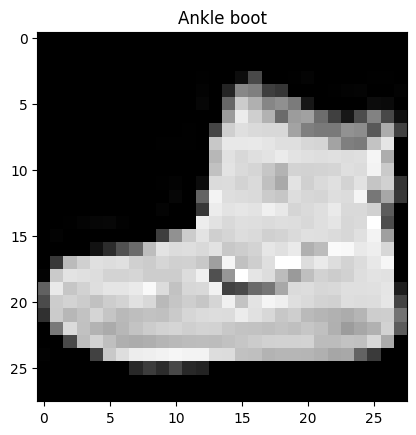

In [6]:
# The dimensions of a gray scale image in pytorch is [1, height, width],
# matplotlib doesn't like this, it expects just 2 dimensions.
# 3 or 4 for colour images
plt.imshow(image.squeeze(), cmap="gray")
plt.title(label)

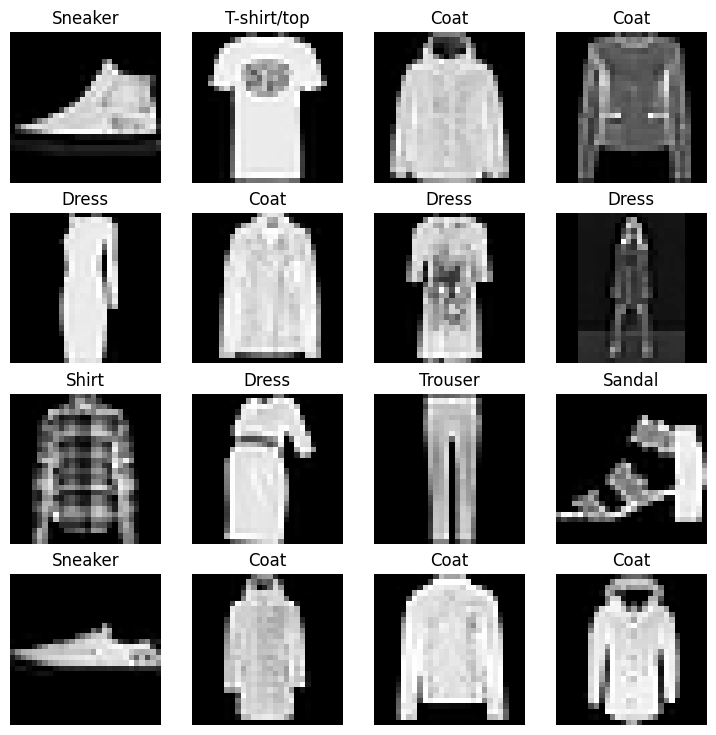

In [7]:
#torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4,4
for i in range (1, rows*cols+1):
  random_index = torch.randint(0,len(train_data), size=[1]).item()
  image, label = train_data[random_index]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze(), cmap="gray")
  plt.title(train_data.classes[label])
  plt.axis(False)

## Prepare DataLoader

Convert Dataset in to a python iterable to be able to create batches (batch size of 32 is common).

(torch.Size([32, 1, 28, 28]), torch.Size([32]))


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

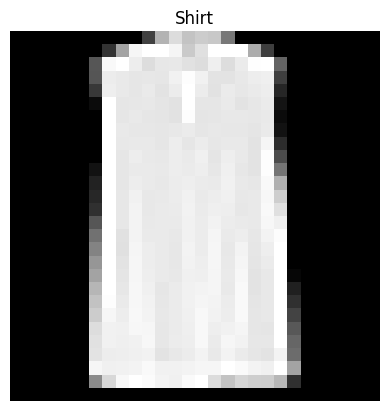

In [8]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(f"{train_features_batch.shape, train_labels_batch.shape}")

# Show a sample
torch.manual_seed(42)
random_index = torch.randint(0, len(train_features_batch), size=[1])

img, label = train_features_batch[random_index], train_data.classes[train_labels_batch[random_index]]

plt.imshow(img.squeeze(), cmap="gray")
plt.title(label)
plt.axis(False)

## Build a baseline model

In [9]:
class FashionMNISTModel_0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
      # We flatten the data as the Linear layers can't handle multi dimensional data.
      nn.Flatten(),
      nn.Linear(in_features=input_shape, out_features=hidden_units),
      # I suspect we will be adding a ReLU here, but not yet apparently....
      nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_stack(x)

In [10]:
torch.manual_seed(42)

model_0 = FashionMNISTModel_0(input_shape=784, hidden_units=10, output_shape=len(train_data.classes))

## Loss function and optimiser

In [11]:
# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup optimiser function
optimiser = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [12]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import accuracy_fn

helper_functions.py already exists, skipping download


## Create timer function

In [13]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
  """Prints differene between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

start_time = timer()
end_time = timer()
print_train_time(start=start_time, end=end_time)

Train time on None: 0.000 seconds


2.167899998539724e-05

## Creating a training loop and training on batches of data.

https://youtu.be/Z_ikDlimN6A?si=2Ddo64iYaopanKnO&t=57094

1. Loop through epochs
2. Loop through training batches, perform training steps, calculate the training loss *per batch*.
3. Loop through testing batchines, perform testing steps, calculate the test loss *per batch*.
4. Print out what's happening.
5. Time it all.

In [14]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()

EPOCHS = 3

for epoch in tqdm(range(EPOCHS)):
  print(f"Epoch: {epoch}")

  train_loss = 0
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()

    y_pred = model_0(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  train_loss /= len(train_dataloader)

  test_loss, test_acc = 0, 0

  model_0.eval()
  with torch.inference_mode():
    for X_test,y_test in test_dataloader:
      test_pred = model_0(X_test)

      test_loss += loss_fn(test_pred, y_test)

      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"Train loss: {train_loss:.4f}, test loss: {test_loss:.4f}, test_acc: {test_acc:.4f}")

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.5904, test loss: 0.5095, test_acc: 82.0387
Epoch: 1
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.4763, test loss: 0.4799, test_acc: 83.1969
Epoch: 2
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.4550, test loss: 0.4766, test_acc: 83.4265
Train time on cpu: 26.329 seconds


## Make predictions and get model results

In [15]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  """Returns a dictionary containing the results of model prediction on data_loader"""
  loss, acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)

      # Accumulate loss and acc per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    # Scale loss and acc to find average per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {
            "model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc
          } # only works when the model was created with a class


In [16]:
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
                             loss_fn=loss_fn, accuracy_fn=accuracy_fn)

model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModel_0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## Create device agnostic code and add non linear functions

https://www.youtube.com/watch?v=Z_ikDlimN6A&t=60116s

In [17]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import requests
from pathlib import Path

from timeit import default_timer as timer

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch torchvision version: {torchvision.__version__}")

device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else torch.device("cpu")
print(f"Torch device: {device}")
if torch.cuda.is_available():
    for device_id in range(torch.cuda.device_count()):
        print(f"Found CUDA device: cuda:{device_id} - {torch.cuda.get_device_name(device_id)}")

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import accuracy_fn

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary containing the results of model prediction on data_loader"""
    loss, acc = 0,0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            # Accumulate loss and acc per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc to find average per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {
        "model_name": model.__class__.__name__,
        "model_loss": loss.item(),
        "model_acc": acc
    } # only works when the model was created with a class

def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints differene between start and end time."""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

class FashionMNISTModel_1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            # We flatten the data as the Linear layers can't handle multi dimensional data.
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_stack(x)

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimiser: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    """Performs a training step with model trying to learn on data_loader"""

    train_loss, train_acc = 0, 0

    model.train()

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        optimiser.zero_grad()

        loss.backward()

        optimiser.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.2f}%")

def nn_test_step(model: torch.nn.Module,
                 device: torch.device,
                 data_loader: torch.utils.data.DataLoader,
                 loss_fn: torch.nn.Module,
                 accuracy_fn,
                 ):
    """Performs a testing step with model trying to test the trained model using data_loader"""
    test_loss, test_acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)

            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}%")

BATCH_SIZE = 32
torch.manual_seed(42)

train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform = torchvision.transforms.ToTensor(),
    target_transform = None
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform = torchvision.transforms.ToTensor(),
    target_transform = None
)

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

model_1 = FashionMNISTModel_1(input_shape=784, hidden_units=10, output_shape=len(train_data.classes)).to(device)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup optimiser function
optimiser = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

train_time_start_on_gpu = timer()

EPOCHS = 3

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}")

    train_step(model=model_1, data_loader=train_dataloader, loss_fn=loss_fn,
               optimiser=optimiser, device=device,
               accuracy_fn=accuracy_fn)

    nn_test_step(model=model_1, device=device, data_loader=test_dataloader,
                 loss_fn=loss_fn, accuracy_fn=accuracy_fn)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=str(next(model_1.parameters()).device))

model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
                             loss_fn=loss_fn, accuracy_fn=accuracy_fn)

PyTorch version: 2.8.0+cu126
PyTorch torchvision version: 0.23.0+cu126
Torch device: cuda
Found CUDA device: cuda:0 - Tesla T4
helper_functions.py already exists, skipping download


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Train loss: 1.0588, Train acc: 62.19%
Test loss: 0.9951, Test acc: 64.1274%
Epoch: 1
Train loss: 0.9133, Train acc: 66.40%
Test loss: 0.9051, Test acc: 66.8630%
Epoch: 2
Train loss: 0.8798, Train acc: 67.24%
Test loss: 0.8948, Test acc: 66.4637%
Train time on cuda:0: 29.441 seconds


  0%|          | 0/313 [00:00<?, ?it/s]

In [18]:
model_0_results, model_1_results

({'model_name': 'FashionMNISTModel_0',
  'model_loss': 0.47663894295692444,
  'model_acc': 83.42651757188499},
 {'model_name': 'FashionMNISTModel_1',
  'model_loss': 0.8947635889053345,
  'model_acc': 66.46365814696486})

https://www.youtube.com/watch?v=Z_ikDlimN6A&t=61985

## Building a Convolution Neural Network (CNN)

CNN's are known for their capability to spot patterns in visual data.

In [64]:
class FashionMNISTModel_2(nn.Module):
  """
  Model architecture that replicates the TinyVGG model from CNN explainer
  website.
  """
  def __init__(self, input_shape:int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(start_dim=0),
        nn.Linear(in_features=hidden_units*7*7, #Output of conv_block_2 assuming input image is 28x28
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.conv_block_1(x)
    print(f"Output shape of conv_block_1 {x.shape}")
    x = self.conv_block_2(x)
    print(f"Output shape of conv_block_2 {x.shape}")
    x = self.classifier(x)
    print(f"Output shape of classifier {x.shape}")
    return x

In [66]:
torch.manual_seed(42)
model_2 = FashionMNISTModel_2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(train_data.classes)).to(device)


### Stepping through `nn.Conv2d`

See docs for `nn.Conv2d()` [here](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64]), dtype: torch.float32
Test image:



torch.Size([10, 64, 64])

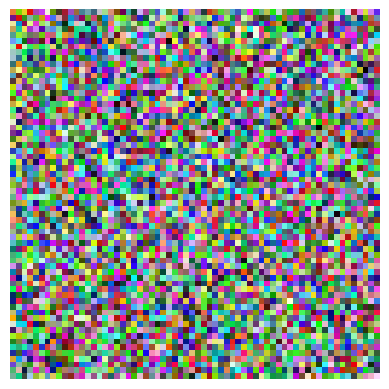

In [65]:
torch.manual_seed(42)

images = torch.randn(size=(32, 3 ,64, 64))
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}, dtype: {test_image.dtype}")
print(f"Test image:\n")
plt.imshow(transforms.ToPILImage()(test_image))
plt.axis(False)

conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3, # A single value is a shortcut to a square of that number, so 3x3 in this case
                       stride=1,
                       padding=1)
conv_output = conv_layer(test_image)
conv_output.shape

### Stepping through `nn.MaxPool2d()`

In [44]:
print(f"Single image shape: {test_image.shape}, dtype: {test_image.dtype}")

max_pool_layer = nn.MaxPool2d(kernel_size=2)
test_image_through_conv = conv_layer(test_image)
print(f"Test image through conv layer shape: {test_image.shape}, dtype: {test_image.dtype}")
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Test image through conv layer and max pool layer shape: {test_image_through_conv_and_max_pool.shape}, dtype: {test_image_through_conv_and_max_pool.dtype}")

Single image shape: torch.Size([3, 64, 64]), dtype: torch.float32
Test image through conv layer shape: torch.Size([3, 64, 64]), dtype: torch.float32
Test image through conv layer and max pool layer shape: torch.Size([10, 32, 32]), dtype: torch.float32


In [46]:
torch.manual_seed(42)
random_tensor = torch.randn(size=(1,2,2))
max_pool_layer = nn.MaxPool2d(kernel_size=2)
max_pool_tensor = max_pool_layer(random_tensor)
print(f"Random tensor: {random_tensor}, shape: {random_tensor.shape}")
print(f"Max pool tensor: {max_pool_tensor}, shape: {max_pool_tensor.shape}")

Random tensor: tensor([[[0.3367, 0.1288],
         [0.2345, 0.2303]]]), shape: torch.Size([1, 2, 2])
Max pool tensor: tensor([[[0.3367]]]), shape: torch.Size([1, 1, 1])


Image shape: torch.Size([1, 28, 28])
Output shape of conv_block_1 torch.Size([10, 14, 14])
Output shape of conv_block_2 torch.Size([10, 7, 7])
Output shape of classifier torch.Size([10])


tensor([ 0.0387, -0.0677,  0.0545, -0.0344, -0.0011,  0.0177, -0.0016, -0.0152,
         0.0229,  0.0072], device='cuda:0', grad_fn=<ViewBackward0>)

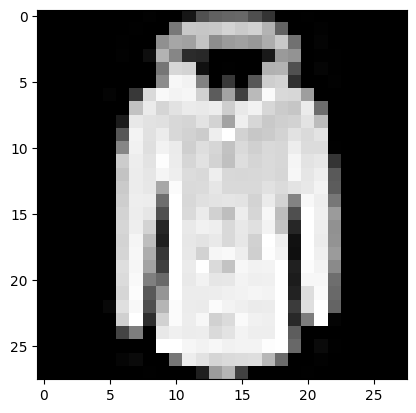

In [67]:
plt.imshow(image.squeeze(), cmap="gray")
print(f"Image shape: {image.shape}")
model_2(image.to(device))

https://www.youtube.com/watch?v=Z_ikDlimN6A&t=66351